## Домашнее задание к занятию "A/B-тесты"

### Описание задачи

![banner](https://storage.googleapis.com/kaggle-datasets-images/635/1204/126be74882028aac7241553cef0e27a7/dataset-original.jpg)

Покемоны - это маленькие существа, которые сражаются друг с другом на соревнованиях. Все покемоны имеют разные характеристики (сила атаки, защиты и т. д.) И относятся к одному или двум так называемым классам (вода, огонь и т. д.).
Профессор Оук является изобретателем Pokedex - портативного устройства, которое хранит информацию обо всех существующих покемонах. Как его ведущий специалист по данным, Вы только что получили от него запрос с просьбой осуществить аналитику данных на всех устройствах Pokedex.

### Описание набора данных
Профессор Оук скопировал все содержимое в память одного устройства Pokedex, в результате чего получился набор данных, с которым Вы будете работать в этой задаче. В этом файле каждая строка представляет характеристики одного покемона:

* `pid`: Numeric - ID покемона
* `HP`: Numeric - Очки здоровья
* `Attack`: Numeric - Сила обычной атаки
* `Defense`: Numeric - Сила обычной защиты
* `Sp. Atk`: Numeric - Сила специальной атаки
* `Sp. Def`: Numeric - Сила специальной защиты
* `Speed`: Numeric - Скорость движений
* `Legendary`: Boolean - «True», если покемон редкий
* `Class 1`: Categorical - Класс покемона
* `Class 2`: Categorical - Класс покемона

In [325]:
import warnings
# Отключение предупреждений (warnings)
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import ttest_ind
from scipy.stats import f_oneway, shapiro
from scikit_posthocs import posthoc_dunn
import matplotlib.pyplot as plt
import seaborn as sns

pokemon = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/datasets_for_t-tests/main/pokemon.csv', on_bad_lines='skip')  # Откроем датасет
pokemon.head()

# Обратите внимание, что у покемона может быть один или два класса.
# Если у покемона два класса, считается, что они имеют одинаковую значимость.

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,False


In [326]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   pid        800 non-null    int64 
 1   Name       799 non-null    object
 2   Class 1    800 non-null    object
 3   Class 2    414 non-null    object
 4   HP         800 non-null    int64 
 5   Attack     800 non-null    int64 
 6   Defense    800 non-null    int64 
 7   Sp. Atk    800 non-null    int64 
 8   Sp. Def    800 non-null    int64 
 9   Speed      800 non-null    int64 
 10  Legendary  800 non-null    bool  
dtypes: bool(1), int64(7), object(3)
memory usage: 63.4+ KB


In [327]:
pokemon.describe()

,pid,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
count,800.0000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,400.5000,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500
std,231.0844,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474
min,1.0000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,200.7500,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000
50%,400.5000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000
75%,600.2500,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000
max,800.0000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000


### Задачи

<div class="alert alert-info">
<b>Задание № 1:</b>
    
Профессор Оук подозревает, что покемоны в классе `Grass` имеют более сильную обычную атаку, чем покемоны в классе `Rock`. Проверьте, прав ли он, и убедите его в своём выводе статистически.
    
    
Примечание: если есть покемоны, которые относятся к обоим классам, просто выбросьте их;
    
Вы можете предположить, что распределение обычных атак является нормальным для всех классов покемонов.

</div>

In [328]:
pok1 = pokemon[~((pokemon['Class 1'] == 'Grass') & (pokemon['Class 2'] == 'Rock') | (pokemon['Class 2'] == 'Grass') & (pokemon['Class 1'] == 'Rock'))]

In [329]:
def define_class(row, title1='Grass', title2='Rock'):
    if row['Class 1'] == title1:
        return title1
    elif row['Class 2'] == title1:
        return title1
    elif row['Class 1'] == title2:
        return title2
    elif row['Class 2'] == title2:
        return title2
    else:
        return 'another'

In [330]:
def proverka_gipotez(p, alfa = 0.05):
    print(p)
    if p>=alfa:
        return "Недостаточно оснований для отклонения H0, статистически значимых отличий нет"
    elif p<alfa:
        return "Отклоняем H0. Есть статистически значимые отличия"
    else:
        return "Введены некорректные данные"

In [331]:
def is_stat_dif_two(np_arr1, np_arr2, alfa=0.05):

    p = ttest_ind(np_arr1, np_arr2, equal_var=False)[1]
    print(p)
    if p>=alfa:
      return 'различия незначительны'
    elif p<alfa:
      return 'выборки статистически различаются'
    else:
      return 'введены некорректные данные'

In [332]:
pok1['Class'] = pok1.apply(lambda row: define_class(row), axis=1)

<Axes: xlabel='Attack'>

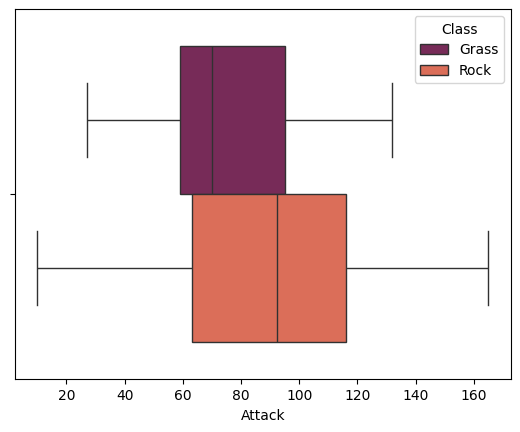

In [333]:
pok11 = pok1[~(pok1['Class'] == 'another')][['Attack', 'Class']]
sns.boxplot(data = pok11, x = 'Attack', hue = 'Class', palette='rocket')

<Axes: xlabel='Attack', ylabel='Count'>

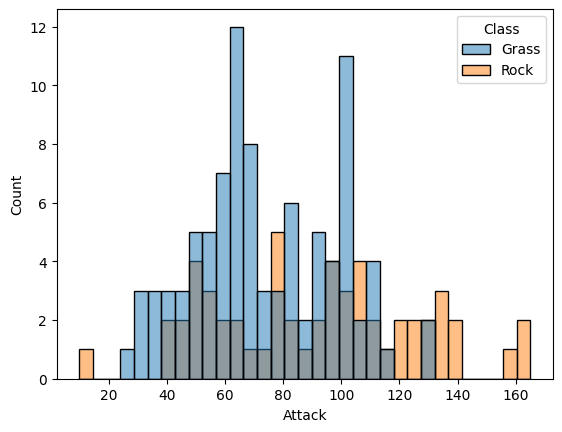

In [334]:
sns.histplot(data=pok11, x="Attack", hue="Class", bins=33)

Ну распределения тут явно ненормальные, скорее мультимодальные, у 'Rock' есть выбросы, как в меньшую, так и в большую сторону.
Нужно выбрать непараметрический тест, нечувствительный к выбросам. И это........ 

In [335]:
stat, p = st.kruskal(pok11[pok11.Class == 'Grass']['Attack'], pok11[pok11.Class == 'Rock']['Attack'])
proverka_gipotez(p)

0.0020133404405618138


'Отклоняем H0. Есть статистически значимые отличия'

Ну и видно, что покемоны класса Rock действительно сильнее в обычной атаке чем Grass. Медиана Rock (50 персентиль) почти совпадает с 75 персентилем Grass.
На всякий случай можем еще другие тесты сделать, чтобы несомневаться

In [336]:
st, p = st.mannwhitneyu(pok11[pok11.Class == 'Grass']['Attack'], pok11[pok11.Class == 'Rock']['Attack'])
proverka_gipotez(p)

0.0020266659144287493


'Отклоняем H0. Есть статистически значимые отличия'

In [337]:
is_stat_dif_two(pok11[pok11.Class == 'Grass']['Attack'], pok11[pok11.Class == 'Rock']['Attack'])

0.0009640546913545304


'выборки статистически различаются'

<div class="alert alert-info">
<b>Задание № 2:</b>
    
Профессор Оук уже долго не может спать по ночам, ведь его волнует вопрос, а правда ли, что покемоны в классе `Water` в среднем быстрее, чем покемоны в классе `Normal`.
    
    
Проверьте, прав ли он, и убедите его в своём выводе статистически.
    
Примечание: если есть покемоны, которые относятся к обоим классам, выбросьте их;
    
Вы можете предположить, что распределение скорости движения является нормальным для всех классов покемонов.
</div>

In [338]:
pok2 = pokemon[~((pokemon['Class 1'] == 'Water') & (pokemon['Class 2'] == 'Normal') | (pokemon['Class 2'] == 'Water') & (pokemon['Class 1'] == 'Normal'))]

In [339]:
pok2['Class'] = pok2.apply(lambda row: define_class(row, title1 = 'Water', title2 = 'Normal'), axis=1)

In [340]:
pok22 = pok2[~(pok2['Class']=='another')][['Class', 'Speed']]

<Axes: xlabel='Speed'>

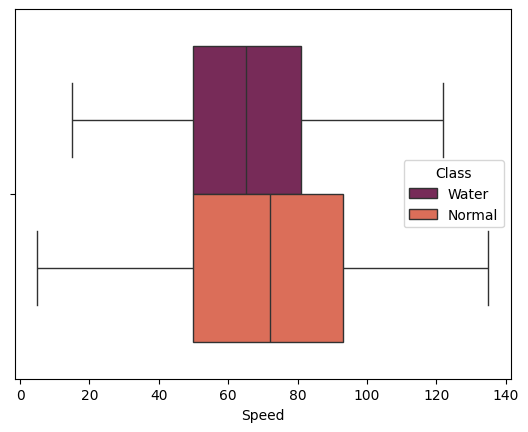

In [341]:
sns.boxplot(data = pok22, x = 'Speed', hue = 'Class', palette='rocket')

<Axes: xlabel='Speed', ylabel='Count'>

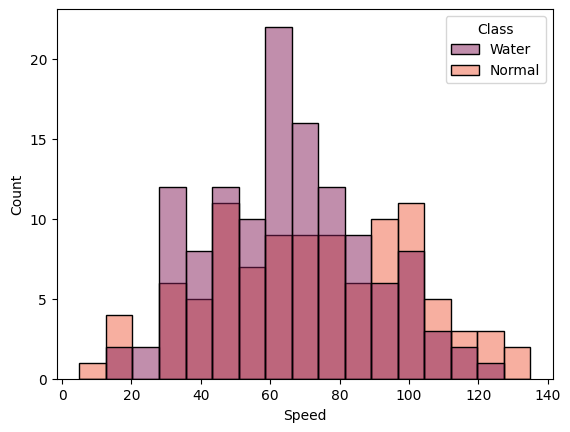

In [342]:
sns.histplot(data=pok22, x="Speed", hue="Class", bins=17, palette='rocket')

Тут распределения достаточны близки к нормальным, Normal по скорости имеет больший разброс, 75 персентиль визуально явно больше у Normal. 50 персентиль тоже больше у Normal.
Значит Water точно не быстрее бегают чем Normal, как минимум также они бегают, но не быстрее, так что профессор может спать спокойно)

In [343]:
is_stat_dif_two(pok22[pok22.Class == 'Water']['Speed'], pok22[pok22.Class == 'Normal']['Speed'])

0.03694772338274292


'выборки статистически различаются'

In [344]:
import scipy.stats as st

In [345]:
stat, p = st.kruskal(pok22[pok22.Class == 'Water']['Speed'], pok22[pok22.Class == 'Normal']['Speed'])
proverka_gipotez(p)

0.03801308625669053


'Отклоняем H0. Есть статистически значимые отличия'

In [346]:
st, p = st.mannwhitneyu(pok22[pok22.Class == 'Water']['Speed'], pok22[pok22.Class == 'Normal']['Speed'])
proverka_gipotez(p)

0.038108151905529956


'Отклоняем H0. Есть статистически значимые отличия'

Вообщем Normal быстрее бегают, чем Water. Но если брать уровень значимости 0.01, то нет оснований для отклонения H0. То есть так то они вообще одинаково бегают. Но я в Пакемонах как то не очень разбираюсь. Поэтому кто я такая, чтобы судить Пакемонов....

<div class="alert alert-info">
<b>Задание № 3:</b>
    
Профессор Оук тот еще безумец. Он изобрёл сыворотку, способную ускорить покемона. Однако мы усомнились в эффективности его вакцины. Професоор дал эту сыворотку следующим покемонам: смотри массив `treathed_pokemon`. Проверьте, работает ли вообще его сыворотка, убедите всех в своём выводе статистически.
    
    
Вы можете предположить, что распределение скорости движения является нормальным для всех классов покемонов.

</div>

In [347]:
# Покемоны, которые принимали сыворотку увеличения скорости
treathed_pokemon = ['Mega Beedrill', 'Mega Alakazam',
                    'Deoxys Normal Forme', 'Mega Lopunny']

In [348]:
speed_up = pokemon[pokemon['Name'].isin(treathed_pokemon)][['Speed']]
speed_norm = pokemon[~pokemon['Name'].isin(treathed_pokemon)][['Speed']]

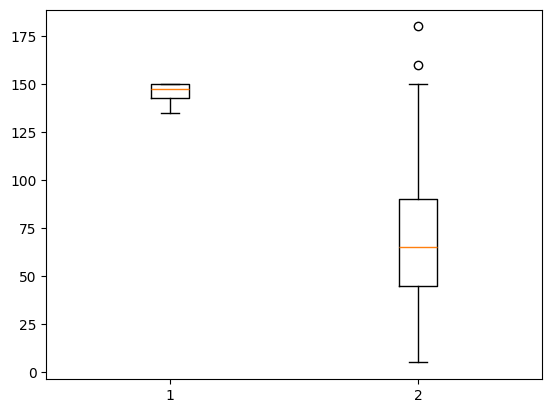

In [349]:
plt.boxplot ([speed_up['Speed'], speed_norm['Speed']])
plt.show()

На этом можно и закончить. Профессор гений!!!!! Но нам нужно проверить гипотезу)))

In [350]:
is_stat_dif_two(speed_up, speed_norm)

[8.10752554e-05]


'выборки статистически различаются'

Отклоняем нулевую гипотезу о равенстве распределений....

<div class="alert alert-info">
<b>Задание № 4:</b>
    
Профессор Оук всегда любил истории про легендарных покемонов. Однако профессор не очень уверен, что они лучше остальных покемонов. Оук предложил разобраться в этом нам. Проверьте, действительно ли сумма характеристик `HP`,`Attack`,`Defense` у легендарных покемонов выше, чем у других покемонов?

А произведение этих же параметров?

Найдите ответы на эти вопросы и убедите всех в своём выводе статистически.
   

Вы можете предположить, что распределение сум и произведений этих параметров является нормальным для всех классов покемонов.

</div>

Из Describe видно, что цифры по этим параметрам соизмеримы, так что их сложение не приведет к нивелированию данных какого либо из параметров.

In [351]:
pok4 = pokemon[['Legendary', 'HP', 'Attack', 'Defense']]

In [352]:
pok4['sum1'] = pok4['HP']+pok4['Attack']+pok4['Defense']
pok4['mult1'] = pok4['HP']*pok4['Attack']*pok4['Defense']

<Axes: xlabel='sum1'>

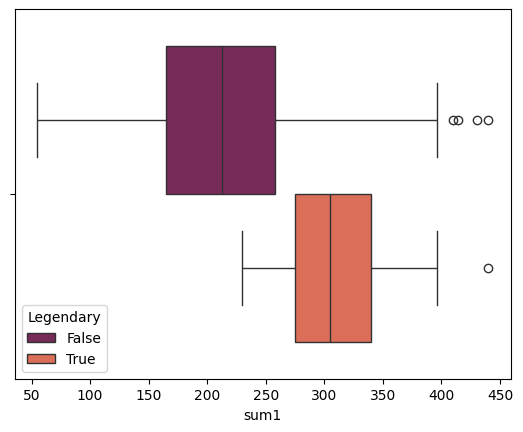

In [353]:
sns.boxplot(data = pok4, x = 'sum1', hue = 'Legendary', palette='rocket')

<Axes: xlabel='mult1'>

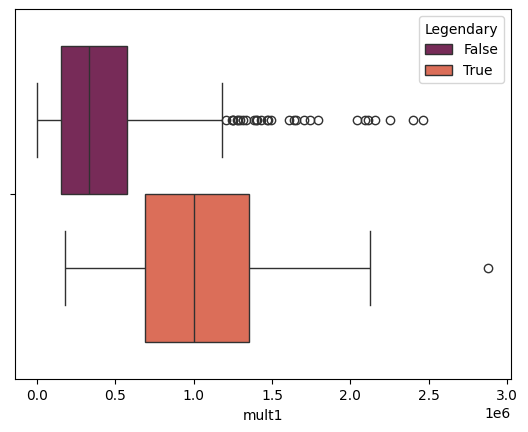

In [354]:
sns.boxplot(data = pok4, x = 'mult1', hue = 'Legendary', palette='rocket')

Действительно выше да. А теперь нужно показать это статистически

In [355]:
legends = pok4[pok4['Legendary'] == True]
usual = pok4[pok4['Legendary'] == False]

In [356]:
is_stat_dif_two(legends.sum1,usual.sum1)

2.928271870332986e-26


'выборки статистически различаются'

In [357]:
is_stat_dif_two(legends.mult1, usual.mult1)

2.895038880907388e-15


'выборки статистически различаются'

In [358]:
import scipy.stats as st

In [359]:
# На всякий случай так как распределение у usual выраженное левосторонее по произведению
stat, p = st.kruskal(legends.mult1, usual.mult1)
proverka_gipotez(p)

2.9465774708771038e-24


'Отклоняем H0. Есть статистически значимые отличия'

Ну и они очень сильно даже визуально различаются, поэтому нет необходимости в проведении других стат тестов. 

<div class="alert alert-info">
<b>Задание № 5:</b>
    
Профессор Оук частенько наблюдает за боями покемонов. После очередных таких боёв Оук выделил четыре класса `best_defence_class`, которые на его взгляд одинаковы по "силе обычной защиты" `Defense`.

Проверьте, действительно ли эти классы покемонов не отличаются по уровню защиты статистически значимо? Всё та же статистика вам в помощь!
   

Вы можете предположить, что распределение параметров защитных характеристик является нормальным для всех классов покемонов.

</div>

In [360]:
best_defence_class = ['Rock', 'Ground', 'Steel', 'Ice']
best_defence_class

['Rock', 'Ground', 'Steel', 'Ice']

In [361]:
pok_rock = pokemon[(pokemon['Class 1'] == 'Rock') | (pokemon['Class 2'] == 'Rock')]                                                    
pok_rock = pok_rock[~(pok_rock['Class 1'].isin(['Ground', 'Steel', 'Ice']))] 
pok_rock = pok_rock[~(pok_rock['Class 2'].isin(['Ground', 'Steel', 'Ice']))]['Defense']                                            

In [362]:
pok_ground = pokemon[(pokemon['Class 1'] == 'Ground') | (pokemon['Class 2'] == 'Ground')]                                                    
pok_ground = pok_ground[~(pok_ground['Class 1'].isin(['Rock', 'Steel', 'Ice']))] 
pok_ground = pok_ground[~(pok_ground['Class 2'].isin(['Rock', 'Steel', 'Ice']))]['Defense']  

In [363]:
pok_steel = pokemon[(pokemon['Class 1'] == 'Steel') | (pokemon['Class 2'] == 'Steel')]                                                    
pok_steel = pok_steel[~(pok_steel['Class 1'].isin(['Rock', 'Ground', 'Ice']))] 
pok_steel = pok_steel[~(pok_steel['Class 2'].isin(['Rock', 'Ground', 'Ice']))]['Defense'] 

In [364]:
pok_ice = pokemon[(pokemon['Class 1'] == 'Ice') | (pokemon['Class 2'] == 'Ice')]                                                    
pok_ice = pok_ice[~(pok_ice['Class 1'].isin(['Rock', 'Ground', 'Steel']))] 
pok_ice = pok_ice[~(pok_ice['Class 2'].isin(['Rock', 'Ground', 'Steel']))]['Defense']

In [365]:
stat, p = st.kruskal(pok_rock, pok_ground, pok_steel, pok_ice)
proverka_gipotez(p)

6.8593498308159615e-06


'Отклоняем H0. Есть статистически значимые отличия'

Проверим между какими группами имеются различия с помощью теста Тьюки

In [366]:
data = [list(pok_rock), list(pok_ground), list(pok_steel), list(pok_ice)]

In [367]:
posthoc_dunn(data, p_adjust = 'bonferroni')

,1,2,3,4
1,1.000000,0.018516,1.000000,0.006852
2,0.018516,1.000000,0.000421,1.000000
3,1.000000,0.000421,1.000000,0.000189
4,0.006852,1.000000,0.000189,1.000000


In [368]:
posthoc_dunn(data)

,1,2,3,4
1,1.000000,0.003086,0.326342,0.001142
2,0.003086,1.000000,0.000070,0.521264
3,0.326342,0.000070,1.000000,0.000031
4,0.001142,0.521264,0.000031,1.000000


Вообщем статистически значимых различий нет между (ice и ground) и между (steel и rock). Между всеми остальными группами различия есть.

# **Примечание:**

Домашнее задание сдается ссылкой [Google Colab](https://colab.research.google.com/). Мы не сможем проверить его или помочь, если вы пришлете:

*   файлы;
*   архивы;
*   скриншоты кода.

Все обсуждения и консультации по выполнению домашнего задания ведутся только на соответствующем канале в Discord.

**Как правильно задавать вопросы аспирантам, преподавателям и коллегам:**

Прежде чем задать вопрос, попробуйте найти ответ в интернете. Навык самостоятельного поиска информации — один из важнейших. Каждый практикующий специалист любого уровня делает это ежедневно.

Сформулируйте вопрос по алгоритму:

1.   Что я делаю?
2.   Какого результата я ожидаю?
3.   Как фактический результат отличается от ожидаемого?
4.   Что я уже попробовал сделать, чтобы исправить проблему?

По возможности прикрепите к вопросу скриншоты либо ссылки на код. Не выкладывайте все решение, оставляйте только проблемный и воспроизводимый участок кода.